# Modeling full data

Since our full data has many features due to node embeddings, we need to use robust models as XGBoost, Support Vector Machine and a Neural Network. The metric chosen metric for this evaluation is F1-Score because both classes have the same weight

## Preparing environment

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import optuna
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing data

In [3]:
train_df = pd.read_csv(paths.data_processed_dir('train_red_processed.csv'))
test_df = pd.read_csv(paths.data_processed_dir('test_red_processed.csv'))

In [4]:
# Saving id_employee_employee for submission

id_col = test_df['id_employee']

In [5]:
y = train_df['resign']

In [6]:
# Dropping unnecessary columns

X = train_df.drop(columns=['id_employee', 'id_last_boss', 'resign'])
X_test = test_df.drop(columns=['id_employee', 'id_last_boss'])

## Preparing cross validation

In [7]:
# Folding data

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Evaluating XGBoost Model

In [8]:
# Creating base model

xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss')

In [9]:
# Making cross-validation in xgboost

cv_results = cross_val_score(xgb_base, X, y, cv=kf, scoring='f1')
cv_results

array([0.73933649, 0.67027027, 0.70157068, 0.70967742, 0.73607748])

Initial f1 results are good, let's optimize the model with cross-validation

In [10]:
# Defining param grid

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

In [11]:
# Defining random search

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    scoring=make_scorer(f1_score),
    n_iter=100,  # Number of different combinations to try
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [12]:
# Optimizing model

random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_t...
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring=make_scorer(f1_score), verbose=2)

In [13]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation F1 score: {random_search.best_score_}")

Best parameters found: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best cross-validation F1 score: 0.7303542179520053


# Evaluating and optimizing neural network

In [14]:
X_train_tensor = torch.from_numpy(X.to_numpy()).float()
X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
y_tensor = torch.from_numpy(y.to_numpy()).long()

In [15]:
# Defining Neural Network

class Net(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, hidden_size, dropout_rate, activation_fn):
        super(Net, self).__init__()
        layers = []
        in_size = input_size
        
        for _ in range(num_layers):
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(activation_fn)
            layers.append(nn.Dropout(dropout_rate))
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

## Defining function to optimize with Optuna

In [16]:
# Defining objective function

def objective(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, log=True)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    # Choose activation function
    if activation_name == 'ReLU':
        activation_fn = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation_fn = nn.LeakyReLU()
    else:
        activation_fn = nn.ELU()
        
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    

    for train_index, val_index in skf.split(X_train_tensor, y_tensor):
        X_train_fold = X_train_tensor[train_index]
        y_train_fold = y_tensor[train_index]
        X_val_fold = X_train_tensor[val_index]
        y_val_fold = y_tensor[val_index]

        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = Net(input_size=X_train_tensor.shape[1],
                    num_classes=2,
                    num_layers=num_layers,
                    hidden_size=hidden_size,
                    dropout_rate=dropout_rate,
                    activation_fn=activation_fn)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Early stopping parameters
        best_val_f1 = 0
        patience = 10
        trigger_times = 0

        for epoch in range(50):  # Max epochs
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())

            val_f1 = f1_score(all_labels, all_preds, average='binary')

            # Early stopping check
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    break  # Early stopping

        f1_scores.append(best_val_f1)

    # Return the average F1-score across folds
    return np.mean(f1_scores)

In [17]:
# Optimizing hyperparameters:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-09-09 22:17:48,794] A new study created in memory with name: no-name-a93f78c5-71c4-43e6-b523-d71626f6e737
[I 2024-09-09 22:18:06,101] Trial 0 finished with value: 0.7233214154371882 and parameters: {'num_layers': 1, 'hidden_size': 56, 'dropout_rate': 0.1759641386783417, 'weight_decay': 0.000828843731613624, 'learning_rate': 0.0003792865555563863, 'batch_size': 32, 'activation': 'ReLU'}. Best is trial 0 with value: 0.7233214154371882.
[I 2024-09-09 22:18:49,223] Trial 1 finished with value: 0.7239221345536904 and parameters: {'num_layers': 2, 'hidden_size': 166, 'dropout_rate': 0.42570522730278104, 'weight_decay': 0.00013713208323292637, 'learning_rate': 0.007858025935698024, 'batch_size': 16, 'activation': 'ELU'}. Best is trial 1 with value: 0.7239221345536904.
[I 2024-09-09 22:19:00,707] Trial 2 finished with value: 0.6426672339847898 and parameters: {'num_layers': 3, 'hidden_size': 211, 'dropout_rate': 0.24882508201237186, 'weight_decay': 0.00019627164977714374, 'learning_rat

In [18]:
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best hyperparameters:
  num_layers: 3
  hidden_size: 44
  dropout_rate: 0.3100113509274515
  weight_decay: 3.9188916442533357e-05
  learning_rate: 0.0005216467129404721
  batch_size: 16
  activation: ELU


## Evaluating best models

### XGBoost

In [19]:
xgb_params = random_search.best_params_

In [20]:
best_xgboost = XGBClassifier(random_state=42, eval_metric='mlogloss',
                             **xgb_params)

In [21]:
# Fitting the model 

best_xgboost.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predicting values

y_pred_xgb = best_xgboost.predict(X_test)

In [23]:
# Saving predicted values

sub_xgb = pd.DataFrame(y_pred_xgb, columns=['abandono_6meses'])
sub_xgb = pd.concat([id_col, sub_xgb], axis=1)
sub_xgb.rename(columns={'id_employee': 'ID'}, inplace=True)
sub_xgb.to_csv('../results/sub_xgb_red.csv', index=False, sep=',')

Kaggle Score:

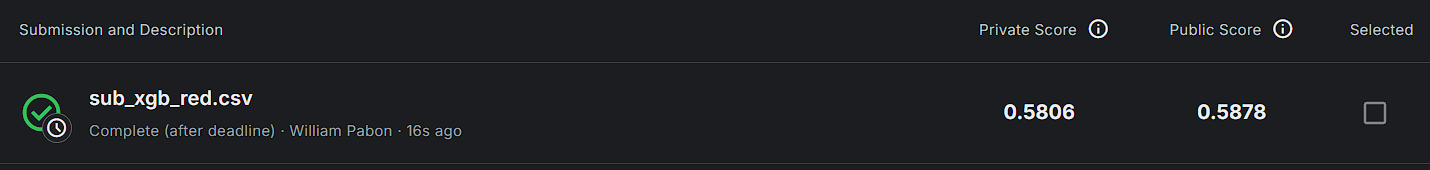

### Neural Network

In [28]:
best_params = study.best_params

# Use the entire training set
train_dataset = TensorDataset(X_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with best hyperparameters
if best_params['activation'] == 'ReLU':
    activation_fn = nn.ReLU()
elif best_params['activation'] == 'LeakyReLU':
    activation_fn = nn.LeakyReLU()
else:
    activation_fn = nn.ELU()

model = Net(input_size=X_train_tensor.shape[1],
            num_classes=2,
            num_layers=best_params['num_layers'],
            hidden_size=best_params['hidden_size'],
            dropout_rate=best_params['dropout_rate'],
            activation_fn=activation_fn
            )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

# Train the model
for epoch in range(50):  # Adjust epochs as needed
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [29]:
# Loading test data
test_loader = DataLoader(X_test_tensor, batch_size=best_params['batch_size'])

# Evaluation
model.eval()
nn_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        # Getting outputs
        outputs = model(X_batch)
        
        # Get the predicted class (0 or 1)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted class to test_predictions
        nn_pred.extend(predicted.cpu().numpy())

In [30]:
# Saving predicted values

sub_nn = pd.DataFrame(nn_pred, columns=['abandono_6meses'])
sub_nn = pd.concat([id_col, sub_nn], axis=1)
sub_nn.rename(columns={'id_employee': 'ID'}, inplace=True)
sub_nn.to_csv('../results/sub_nn_red.csv', index=False, sep=',')

Kaggle Score:

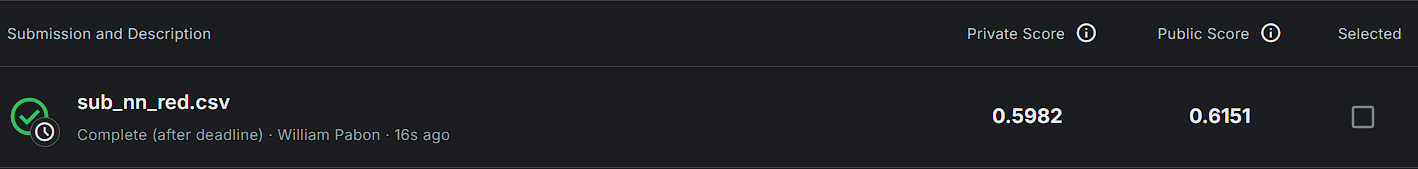